In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import matplotlib.pylab as plt

from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', 100)

In [3]:
Cases = pd.read_csv('data/Cases2018.csv', encoding='iso-8859-1')
OldCases = pd.read_csv('data/OldCases.csv', encoding='iso-8859-1')

In [4]:
FullCases = Cases.append(OldCases)

In [5]:
len(FullCases)

28754

In [6]:
unneeded =FullCases[['caseId','docketId','lexisCite','term','naturalCourt','docket','chief','caseName','caseIssuesId','voteId','dateDecision', 'decisionType','usCite','sctCite','ledCite', 'issue','issueArea','decisionDirection','decisionDirectionDissent','authorityDecision1','authorityDecision2','lawType','lawSupp','lawMinor','majOpinWriter','majOpinAssigner']]
labels =FullCases[['declarationUncon', 'caseDisposition', 'caseDispositionUnusual','partyWinning', 'precedentAlteration','voteUnclear','splitVote','majVotes','minVotes']]

In [7]:
FullCases.drop(unneeded, axis=1, inplace=True)
FullCases.drop(labels, axis=1, inplace=True)

In [8]:
FullCases[['dateArgument','dateRearg']]=FullCases[['dateArgument', 'dateRearg']].notnull().astype(int)

In [9]:
FullCases[['petitionerState','adminActionState','threeJudgeFdc','respondentState',]] = FullCases[['petitionerState','adminActionState','threeJudgeFdc','respondentState',]].fillna(value=0.0)
FullCases['respondent'] = FullCases[['respondent']].fillna(value=501)# There was already a code for unidentfiable which i reused for NaN here
FullCases['adminAction'] = FullCases[['adminAction']].fillna(value=118.0)# There was already a code for unidentfiable which i reused for NaN here
FullCases['caseOrigin'] = FullCases[['caseOrigin']].fillna(value=0.0)#meaning originated in supreme court
FullCases['caseSource'] = FullCases[['caseSource']].fillna(value=0.0)##meaning originated in supreme court
FullCases['caseOriginState'] = FullCases[['caseOriginState']].fillna(value=0.0)
FullCases['caseSourceState'] = FullCases[['caseSourceState']].fillna(value=0.0)
FullCases['lcDisagreement'] = FullCases[['lcDisagreement']].fillna(value=0.0)
FullCases['certReason'] = FullCases[['certReason']].fillna(value=12)
FullCases['lcDisposition'] = FullCases[['lcDisposition']].fillna(value=0.0)
FullCases['lcDispositionDirection'] = FullCases[['lcDispositionDirection']].fillna(value=3.0)

In [10]:
finalLabels = labels['partyWinning']
FullCases['result'] = labels['partyWinning']

In [11]:
FullCases['result'] = FullCases[['result']].fillna(value=2.0)

In [12]:
FullCases.drop(FullCases[FullCases.result==2.0].index, inplace = True)

In [13]:
labels2 = FullCases[['result']]

In [14]:
FullCases.drop('result', axis=1, inplace=True)

In [15]:
def cats(DF):
    for i in DF.columns:
        DF[i] = pd.Categorical(DF[i])
    return DF

In [16]:
cats(FullCases)
FullCases2 = FullCases

In [17]:
binCols = ['dateArgument', 'dateRearg','threeJudgeFdc','lcDisagreement']
# Takes all 14 other columns
dummy_cols = list(set(FullCases2.columns) - set(binCols))

In [18]:
FullCases2 = pd.get_dummies(FullCases2, columns=dummy_cols, drop_first=True)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(FullCases2, labels2, test_size=0.2, random_state=23)

In [20]:
y_test = np.ravel(y_test)
y_train = np.ravel(y_train)

In [33]:
params = {'n_estimators': 1000, 'learning_rate': 0.001, 'random_state':23, 'max_depth' :5}
GBC = GradientBoostingClassifier(**params)

In [34]:
GBC.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.001, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=23,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [35]:
GBC.score(X_test, y_test), GBC.score(X_train, y_train)

(0.6606981370953157, 0.6682944474588534)

Text(0, 0.5, 'Deviance')

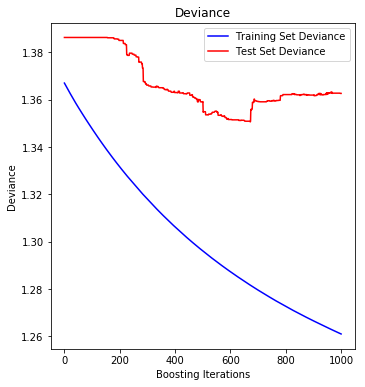

In [39]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(GBC.staged_predict(X_test)):
    test_score[i] = GBC.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, GBC.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

In [41]:
feature_importance = GBC.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())

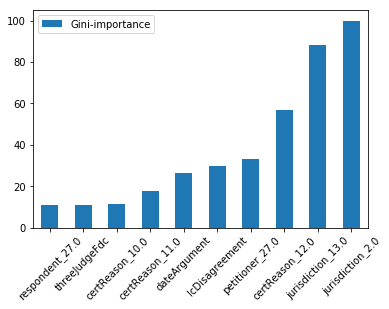

In [48]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(FullCases2.columns, feature_importance):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
imprten = importances.sort_values(by='Gini-importance').tail(10)
imprten.plot(kind='bar', rot=45)

In [43]:
importances2.head(10)

NameError: name 'importances2' is not defined

In [37]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, GBC.predict(X_test)).ravel()
(tn, fp, fn, tp)

(2531, 582, 1294, 1122)

In [38]:
def permutation_importances(rf, X_train, y_train, metric):
    baseline = metric(rf, X_train, y_train)
    imp = []
    for col in X_train.columns:
        save = X_train[col].copy()
        X_train[col] = np.random.permutation(X_train[col])
        m = metric(rf, X_train, y_train)
        X_train[col] = save
        imp.append(baseline - m)
    return np.array(imp)

In [49]:
wins.head()

NameError: name 'wins' is not defined